In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from google.colab.patches import cv2_imshow
from os import listdir
from os.path import isfile, join

from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten

# Load Dataset

In [2]:
!git clone https://github.com/seensiravit/Parkinson-Early-Detection.git

Cloning into 'Parkinson-Early-Detection'...
remote: Enumerating objects: 294, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 294 (delta 10), reused 15 (delta 1), pack-reused 253
Receiving objects: 100% (294/294), 66.00 MiB | 31.94 MiB/s, done.
Resolving deltas: 100% (11/11), done.


In [3]:
PD_data_path = '/content/Parkinson-Early-Detection/dataset/HandPD/spiral/HealthySpiral'
H_data_path = '/content/Parkinson-Early-Detection/dataset/HandPD/spiral/HealthySpiral'

In [4]:
H_img = [H_data_path+'/'+f for f in listdir(H_data_path)]
PD_img = [PD_data_path+'/'+f for f in listdir(PD_data_path)]

In [5]:
print(H_img[:5])
print(PD_img[:5])

['/content/Parkinson-Early-Detection/dataset/HandPD/spiral/HealthySpiral/sp2-H33.jpg', '/content/Parkinson-Early-Detection/dataset/HandPD/spiral/HealthySpiral/sp2-H12.jpg', '/content/Parkinson-Early-Detection/dataset/HandPD/spiral/HealthySpiral/sp4-H3.jpg', '/content/Parkinson-Early-Detection/dataset/HandPD/spiral/HealthySpiral/sp2-H18.jpg', '/content/Parkinson-Early-Detection/dataset/HandPD/spiral/HealthySpiral/sp1-H35.jpg']
['/content/Parkinson-Early-Detection/dataset/HandPD/spiral/HealthySpiral/sp2-H33.jpg', '/content/Parkinson-Early-Detection/dataset/HandPD/spiral/HealthySpiral/sp2-H12.jpg', '/content/Parkinson-Early-Detection/dataset/HandPD/spiral/HealthySpiral/sp4-H3.jpg', '/content/Parkinson-Early-Detection/dataset/HandPD/spiral/HealthySpiral/sp2-H18.jpg', '/content/Parkinson-Early-Detection/dataset/HandPD/spiral/HealthySpiral/sp1-H35.jpg']


In [6]:
def display_image(path) :
  image = cv2.imread(path , 1)
  cv2_imshow(image)
  cv2.waitKey(0)
  cv2.destroyAllWindows()

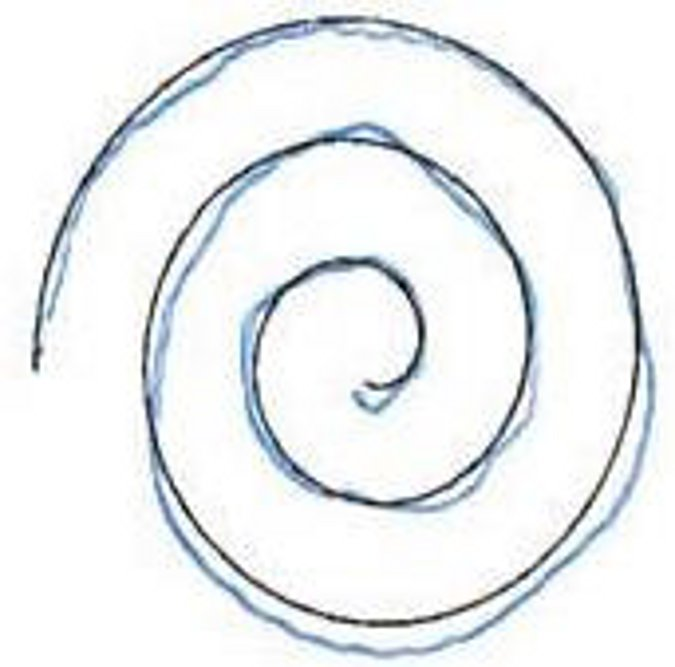

In [7]:
display_image(H_img[0])

# Split Data

# Create Dataframe (Image)

In [8]:
df_img = pd.concat([pd.DataFrame({'PNG':path , 'PD':'Healthy'} for path in H_img) , pd.DataFrame({'PNG':path , 'PD':'Patient'} for path in PD_img)] , ignore_index=True)
df_img

,PNG,PD
0,/content/Parkinson-Early-Detection/dataset/Han...,Healthy
1,/content/Parkinson-Early-Detection/dataset/Han...,Healthy
2,/content/Parkinson-Early-Detection/dataset/Han...,Healthy
3,/content/Parkinson-Early-Detection/dataset/Han...,Healthy
4,/content/Parkinson-Early-Detection/dataset/Han...,Healthy
...,...,...
275,/content/Parkinson-Early-Detection/dataset/Han...,Patient
276,/content/Parkinson-Early-Detection/dataset/Han...,Patient
277,/content/Parkinson-Early-Detection/dataset/Han...,Patient
278,/content/Parkinson-Early-Detection/dataset/Han...,Patient


In [9]:
df_img = df_img.sample(frac = 1)
df_img = df_img.reset_index(drop = True)
df_img

,PNG,PD
0,/content/Parkinson-Early-Detection/dataset/Han...,Patient
1,/content/Parkinson-Early-Detection/dataset/Han...,Patient
2,/content/Parkinson-Early-Detection/dataset/Han...,Healthy
3,/content/Parkinson-Early-Detection/dataset/Han...,Patient
4,/content/Parkinson-Early-Detection/dataset/Han...,Patient
...,...,...
275,/content/Parkinson-Early-Detection/dataset/Han...,Healthy
276,/content/Parkinson-Early-Detection/dataset/Han...,Patient
277,/content/Parkinson-Early-Detection/dataset/Han...,Patient
278,/content/Parkinson-Early-Detection/dataset/Han...,Healthy


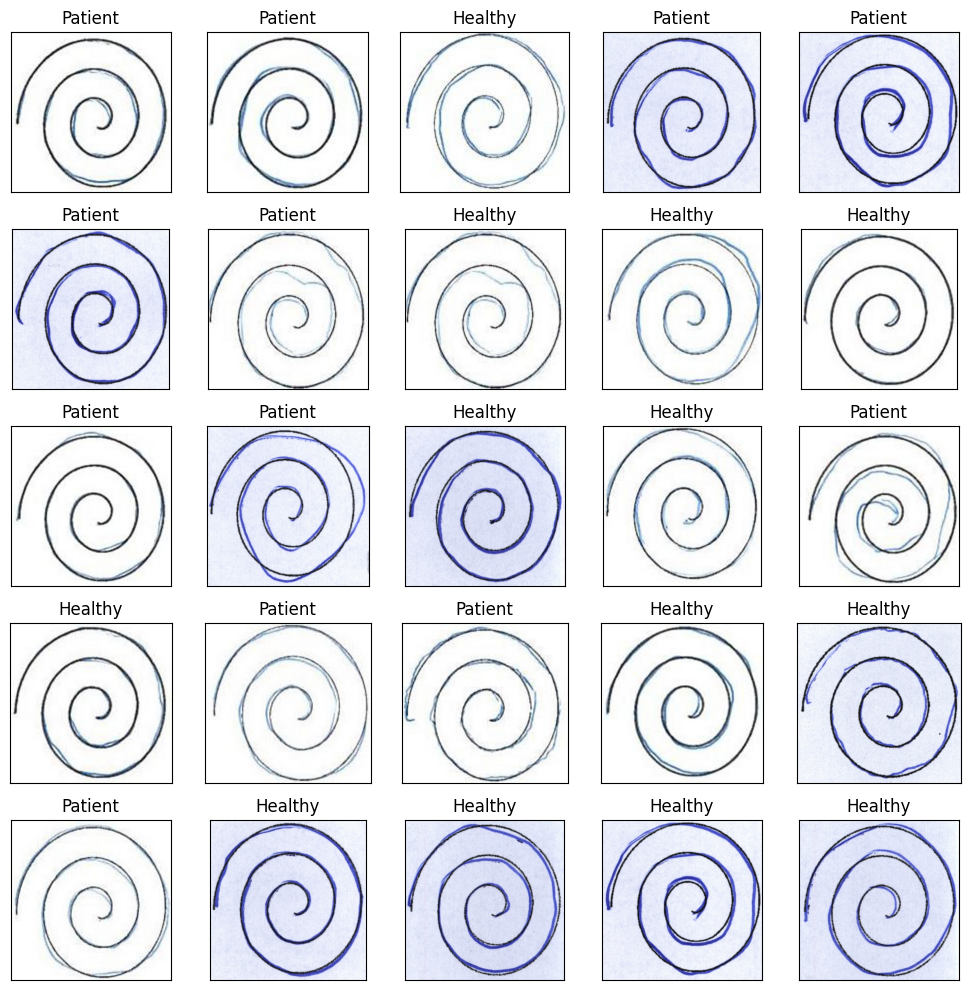

In [10]:
fig, axes = plt.subplots(nrows=5,
                        ncols=5,
                        figsize=(10,10),
                        subplot_kw={"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_img["PNG"][i]))
    ax.set_title(df_img["PD"][i])
plt.tight_layout()
plt.show()

# Split Data

In [11]:
train_valid_df , test_df = train_test_split(df_img , test_size=0.08)
train_df , valid_df = train_test_split(train_valid_df , test_size=0.08)

In [12]:
print(f'train {train_df.shape}')
print(f'valid {valid_df.shape}')
print(f'test {test_df.shape}')

train (236, 2)
valid (21, 2)
test (23, 2)


# Pre Processing

In [13]:
from keras.preprocessing.image import ImageDataGenerator

In [14]:
train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [15]:
train_generator = train_datagen.flow_from_dataframe(train_df , x_col="PNG" , y_col="PD" , class_mode="binary" ,  target_size = (224, 224))
valid_generator = test_datagen.flow_from_dataframe(valid_df , x_col="PNG" , y_col="PD" , class_mode="binary" ,  target_size = (224, 224))

Found 236 validated image filenames belonging to 2 classes.
Found 21 validated image filenames belonging to 2 classes.


In [16]:
train_generator.image_shape

(224, 224, 3)

# VGG16

In [17]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

58889256/58889256 [==============================] - 1s 0us/step


In [18]:
for layer in base_model.layers:
    layer.trainable = False

In [24]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01), loss = 'binary_crossentropy',metrics = ['acc'])

In [25]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

## Fit data

In [26]:
hist = model.fit(train_generator, validation_data = valid_generator, epochs = 50)

Epoch 1/50
8/8 [==============================] - 5s 505ms/step - loss: 139.1316 - acc: 0.4915 - val_loss: 22.4206 - val_acc: 0.6190
Epoch 2/50
8/8 [==============================] - 4s 479ms/step - loss: 23.9327 - acc: 0.5127 - val_loss: 18.6809 - val_acc: 0.3810
Epoch 3/50
8/8 [==============================] - 5s 625ms/step - loss: 18.7472 - acc: 0.4661 - val_loss: 11.3392 - val_acc: 0.3810
Epoch 4/50
8/8 [==============================] - 4s 470ms/step - loss: 7.5680 - acc: 0.5042 - val_loss: 2.6903 - val_acc: 0.6190
Epoch 5/50
8/8 [==============================] - 5s 633ms/step - loss: 2.3058 - acc: 0.4195 - val_loss: 3.9170 - val_acc: 0.6190
Epoch 6/50
8/8 [==============================] - 4s 469ms/step - loss: 1.5856 - acc: 0.4788 - val_loss: 1.7662 - val_acc: 0.6190
Epoch 7/50
8/8 [==============================] - 6s 765ms/step - loss: 1.0588 - acc: 0.4958 - val_loss: 0.6947 - val_acc: 0.3810
Epoch 8/50
8/8 [==============================] - 4s 525ms/step - loss: 0.7017 - ac

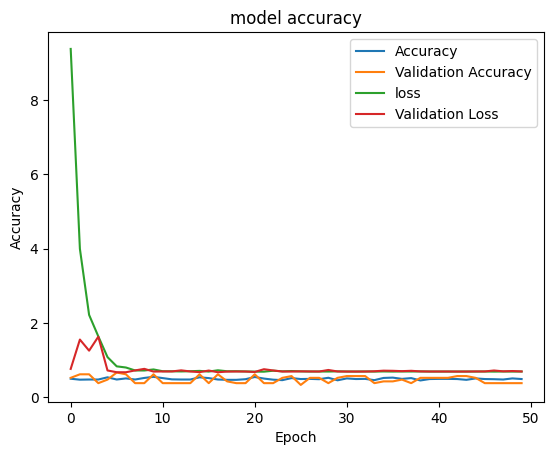

In [22]:
plt.plot(hist.history["acc"])
plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

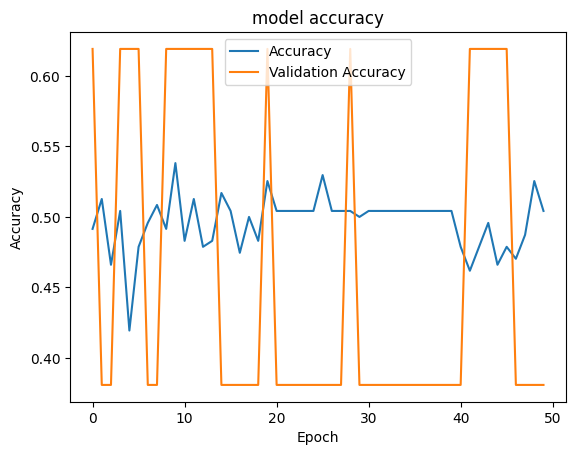

In [27]:
plt.plot(hist.history["acc"])
plt.plot(hist.history['val_acc'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

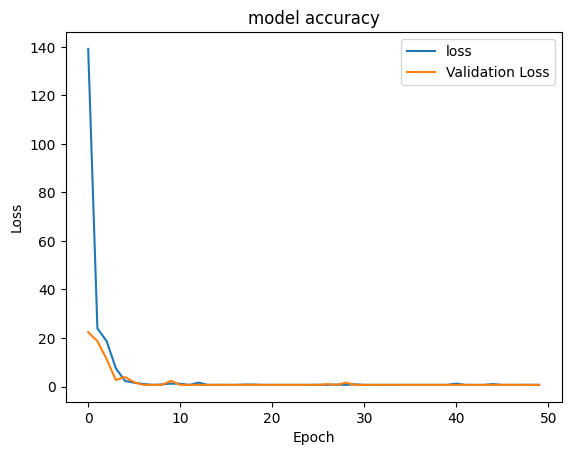

In [28]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])
plt.show()